<a href="https://colab.research.google.com/github/YMGYM/TSE_Learning/blob/master/Beijjing_air_pollution_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

이 파일은 황철현, 신강욱의
`미세먼지 예측 성능 개선을 위한 CNN-LSTM 결합 방법`
논문의 구현 연습 파일입니다.

데이터셋은 [Beijing PM2.5 데이터셋](https://www.kaggle.com/djhavera/beijing-pm25-data-data-set)
을 사용핬습니다.

# Load Data

In [1]:
! unzip /content/drive/My\ Drive/Datasets/beijing_air.zip -d data

Archive:  /content/drive/My Drive/Datasets/beijing_air.zip
  inflating: data/PRSA_data_2010.1.1-2014.12.31.csv  


In [2]:
import pandas as pd

In [88]:
data = pd.read_csv('/content/data/PRSA_data_2010.1.1-2014.12.31.csv')

In [89]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


- DEWP : 이슬점 온도
- PRES : 기압
- cbwd : Combined wind direction 
- IWS : Cumulated wind speed (m/s) 
- Is : Cumulated hours of snow 
- Ir : Cumulated hours of rain 

In [90]:
dropped_data = data.drop(['No', 'year', 'month', 'day', 'hour'],axis=1)

In [91]:
dropped_data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [92]:
pm25 = dropped_data.pop('pm2.5')

In [93]:
dropped_data

,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,-21,-11.0,1021.0,NW,1.79,0,0
1,-21,-12.0,1020.0,NW,4.92,0,0
2,-21,-11.0,1019.0,NW,6.71,0,0
3,-21,-14.0,1019.0,NW,9.84,0,0
4,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...
43819,-23,-2.0,1034.0,NW,231.97,0,0
43820,-22,-3.0,1034.0,NW,237.78,0,0
43821,-22,-3.0,1034.0,NW,242.70,0,0
43822,-22,-4.0,1034.0,NW,246.72,0,0


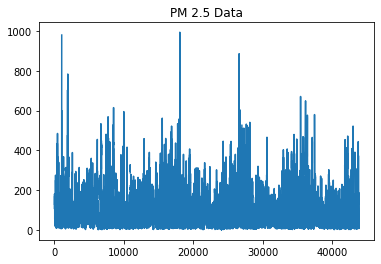

In [94]:
import matplotlib.pyplot as plt

plt.title("PM 2.5 Data")
plt.plot(pm25)
plt.show()

# NaN Data fix
결측치 값을 확인하여 제거합니다.
[이곳](https://rfriend.tistory.com/262?category=675917) 을 참고했습니다.

In [96]:
pm25.isnull().sum()

0

In [95]:
pm25 = pm25.fillna(pm25.mean())

In [67]:
pm25 = pm25.dropna()

AttributeError: ignored

# Make Time Series

데이터를 주어진 타임별 시계열 데이터로 전환합니다.

print_data(origin, xs, ys, time) 함수를 통해 임의의 시간에서 결과값을 확인해 봅니다.

In [11]:
import numpy as np

In [28]:
def print_data(origin, xs, ys, time):
  import random
  cnt = random.randint(0, len(data))

  print(f"The {cnt} number of origin is {origin[cnt]}\n")
  print(f"The {cnt} + {time} number of origin is {origin[cnt + time]}\n")
  print(f"The {cnt} number of xs is {xs[cnt]}\n")
  print(f"The next of ys is {ys[cnt]}\n")

In [29]:
def make_timeSerise(data, time):
  input = np.array([])
  output = np.array([])

  for t in range(0, len(data) - time -1):

    if t == 0:
      input = np.append(input, data[:time])
      output = np.append(output, data[time])
    else:
      input = np.vstack((input, data[t: t+time]))
      output = np.vstack((output, data[t + time]))

  print("----------------Correct Check----------------")
  print(f"xs.shape is {input.shape}\n")
  print(f"ys.shape is {output.shape}\n")
  print_data(data, input, output, time)
  return input, output

In [98]:
xs, ys = make_timeSerise(pm25, 15)

----------------Correct Check----------------
xs.shape is (43808, 15)

ys.shape is (43808, 1)

The 5338 number of origin is 166.0

The 5338 + 15 number of origin is 81.0

The 5338 number of xs is [166. 223. 181. 128. 117.  97.  96.  79.  61.  66.  69.  76.  81.  70.
  83.]

The next of ys is [81.]



In [30]:
print_data(pm25, xs, ys, 15) # for debugging

The 17081 number of origin is 238.0

The 17081 + 15 number of origin is 11.0

The 17081 number of xs is [238. 247. 279. 304. 320. 282.  56.  16.  15.  14.  14.  13.  10.  10.
  11.]

The next of ys is [11.]



## Using Keras Function
케라스의 Time Series Generator 을 사용해 제너레이터를 생성함

In [118]:
import tensorflow as tf
import tensorflow.keras as K

In [152]:
input_target = pm25[:-15]
output_target = pm25[15:]

In [153]:
data_gen = K.preprocessing.sequence.TimeseriesGenerator(input_target, output_target, length=15, shuffle=True)

In [130]:
x, y = data_gen[0]

In [180]:
y.shape

(128, 1)

## Make test_dataset
검증 데이터셋을 만듭니다.

In [192]:
def make_test_data(xs, ys, rate):
  arrlen = int(len(xs) * (rate))
  np.random.shuffle(xs)
  np.random.shuffle(ys)

  xs_train, xs_val, xs_test = xs[:-1 * (arrlen * 2)], xs[-1 * (arrlen * 2) : -1 * (arrlen)], xs[-1 * (arrlen):]
  ys_train, ys_val, ys_test = ys[:-1 * (arrlen * 2)], ys[-1 * (arrlen * 2) : -1 * (arrlen)], ys[-1 * (arrlen):]

  # xs_train = xs_train.reshape(-1, 1, 15)
  # xs_val = xs_val.reshape(-1, 1, 15)
  # xs_test = xs_test.reshape(-1, 1, 15)
  # ys_train = ys_train.reshape(-1, 1, 1)
  # ys_val = ys_val.reshape(-1, 1, 1)
  # ys_test = ys_test.reshape(-1, 1, 1)

  return (xs_train, ys_train), (xs_val, ys_val), (xs_test, ys_test)

In [193]:
(xs_train, ys_train), (xs_val, ys_val), (xs_test, ys_test) = make_test_data(xs, ys, 0.1)

In [194]:
xs_train.shape

(35048, 15)

# Prediction(basic LSTM)
기본적인 LSTM모델을 활용해 예측해 봅니다.

In [41]:
import tensorflow as tf
import tensorflow.keras as K

In [199]:
model = K.Sequential()
model.add(K.layers.BatchNormalization(input_shape=(x.shape[1],)))
model.add(K.layers.Reshape((1,15)))
model.add(K.layers.LSTM(216, return_sequences=True))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation="relu"))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(1, activation="sigmoid"))

In [200]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_35 (Batc (None, 15)                60        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 15)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 216)            200448    
_________________________________________________________________
batch_normalization_36 (Batc (None, 1, 216)            864       
_________________________________________________________________
dense_29 (Dense)             (None, 1, 128)            27776     
_________________________________________________________________
batch_normalization_37 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_30 (Dense)             (None, 1, 1)            

In [201]:
model.compile(optimizer="adam", loss=K.losses.CategoricalCrossentropy())
# model.compile(optimizer="adam", loss="MSE")

In [ ]:
model.fit(x=data_gen, epochs=10)
# model.fit(x=xs_train, y=ys_train, epochs=50, batch_size=128, validation_data=(xs_val, ys_val))

Epoch 1/10
343/343 [==============================] - 10s 28ms/step - loss: 17671.3301
Epoch 2/10
343/343 [==============================] - 9s 28ms/step - loss: 17338.7988
Epoch 3/10
343/343 [==============================] - 9s 27ms/step - loss: 17546.9336
Epoch 4/10
 18/343 [>.............................] - ETA: 8s - loss: 17146.9219